# Final Project
This demo file shows the preliminary knowledge for the final project.

## Preprocessing data
Preprocessing will include clean data, lower docs, tokenization, filtering, etc. The final goal of preprocessing is to build a vocab with the given corpus, so that you could vectorize your docs with bag-of-words.

### Fetch the raw data from the 20newsgroup corpora

In [2]:
!pip install stop_words
!pip install  --upgrade gensim --pre
!pip install wordcloud

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=727f627a600e1ae9fc100968ecc78e681479a26386654d8f108edbd80f81176d
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
     |████████████████████████████████| 24.1 MB 11.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups

# we load both training and testing splits as our final project mainly focuses on the unsupervised setting. 
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[0])

From: cubbie@garnet.berkeley.edu (                               )
Subject: Re: Cubs behind Marlins? How?
Article-I.D.: agate.1pt592$f9a
Organization: University of California, Berkeley
Lines: 12
NNTP-Posting-Host: garnet.berkeley.edu


gajarsky@pilot.njin.net writes:

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

       This season so far, Morgan and Guzman helped to lead the Cubs
       at top in ERA, even better than THE rotation at Atlanta.
       Cubs ERA at 0.056 while Braves at 0.059. We know it is early
       in the season, we Cubs fans have learned how to enjoy the
       short triumph while it is still there.



### Clean the raw data

In [4]:
# Sklearn already implements an interface for this step.
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(dataset.data[0])


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)


In [5]:
corpus = dataset.data # save as the raw docs
labels = dataset.target # labels for clustering evaluation or supervised tasks
print(len(corpus), len(labels))
print(labels)
print(dataset.target_names)

18846 18846
[ 9  4 11 ...  4  6  7]
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [6]:
# Let's show the first 10 documents
for i in range(10):
    doc = corpus[i]
    category = dataset.target_names[labels[i]]
    print("The {}-th sent of {}: {}".format(i+1, category, doc))
    print("==================================================\n")

The 1-th sent of rec.sport.baseball: 
morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

The 2-th sent of comp.sys.mac.hardware: Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wou

### Tokenization

In [7]:
# So, appraently, we need do more Pre-processing step
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from pprint import pprint

def pre_processing(docs):
    tokenizer = RegexpTokenizer(r"\w+(?:[-'+]\w+)*|\w+")
    en_stop = get_stop_words('en')
    ps = PorterStemmer()
    # tokenization
    tokens_text = preprocess_string(docs)
    stopped_tokens_text = [i for i in tokens_text if not i in en_stop]
    # remoce digis and one-charcter word
    doc = [token for token in stopped_tokens_text if not token.isnumeric()]
    doc = [token for token in doc if len(token) > 1]
    # you could always add some new preprocessing here
    doc = [ps.stem(token) for token in doc if len(token) > 1]
    return doc

doc1 = remove_stopwords(corpus[0])
doc2 = preprocess_string(corpus[0])
doc3 = pre_processing(corpus[0])
print(dataset.data[0])
print(doc1)
print("=========================")
print(doc2)
print(doc3)


morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)
morgan guzman era's 1 run higher year, cubs idiots pitch harkey hibbard. castillo won't good (i think he's stud pitcher)
['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']
['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']


### Build vocab

1000
['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']
11607
21
6270


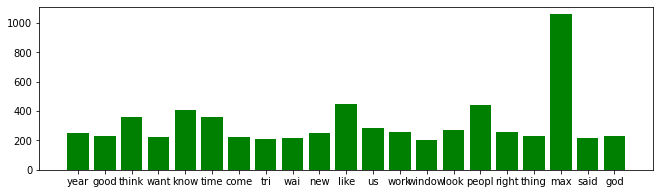

In [8]:
# Let's first get a new corpus by using one tokenization method above
# Also, for illustration purpose, we only take the first 1000 docs from the original corpus
import matplotlib.pyplot as plt

corpus1 = [pre_processing(corpus[i]) for i in range(1000)]
print(len(corpus1))
print(corpus1[0])
# Then we build the vocab
freqs = defaultdict(int)
for doc in corpus1:
    doc_list = list(doc)
    for w in doc_list:
      freqs[w] += 1
print(len(freqs))
vocab = [w for w in freqs if freqs[w]>1]
freqs_limit = {w:freqs[w] for w in freqs if freqs[w]>200}
print(len(freqs_limit))
print(len(vocab))
plt.rcParams["figure.figsize"] = (11,3)
plt.bar(freqs_limit.keys(), freqs_limit.values(), color ='green')
plt.show()

In [9]:
from copy import deepcopy
# A more efficient way is to use gensim.corpora
dictionary = corpora.Dictionary(corpus1)
print(dictionary)
# Prune the dict by filtering with document freq (DF)
dict1 = deepcopy(dictionary)
dict1.filter_extremes(no_below=5, no_above=0.5)# no_below and no_above are related to DF
print(dict1)
dict2 = deepcopy(dictionary)
dict2.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
print(dict2)
# You may also use the freqs to filter dict with TF
low_tf_tokens = [w for w in freqs if freqs[w]<=3]
remove_ids = [dictionary.token2id[w] for w in low_tf_tokens]
print(len(remove_ids))
dictionary.filter_tokens(remove_ids)
dictionary.compactify()  # remove gaps in id sequence after words that were removed
print(dictionary)
# dictionray.cfs collects all the term freqs, similar to freqs
# Let's check if the new dictionary still has token with a tf <= 3
print(len([w for w in dictionary.cfs if dictionary.cfs[w]<=3]))

# Don't forget to save your vocab 
dictionary.save('dict_1.txt')

Dictionary(11607 unique tokens: ['castillo', 'cub', 'era', 'good', 'guzman']...)
Dictionary(2276 unique tokens: ['era', 'good', 'higher', 'idiot', 'pitch']...)
Dictionary(2000 unique tokens: ['era', 'good', 'higher', 'idiot', 'pitch']...)
8025
Dictionary(3582 unique tokens: ['cub', 'era', 'good', 'higher', 'idiot']...)
0


### Vectorize the corpus

In [10]:
# You vocab/dictionary finally define your corpus
pprint(dictionary.token2id)

{'ab': 3123,
 'abandon': 1190,
 'abc': 3220,
 'abil': 1191,
 'abl': 656,
 'abolish': 2918,
 'abort': 2555,
 'absolut': 1334,
 'absurd': 3389,
 'abu': 74,
 'accel': 976,
 'accept': 741,
 'access': 400,
 'accid': 2770,
 'accomod': 1052,
 'accomplish': 1464,
 'accord': 932,
 'account': 1082,
 'accu': 1192,
 'accur': 2718,
 'achiev': 1465,
 'ack': 3296,
 'acknowledg': 2107,
 'acm': 75,
 'acquisit': 2379,
 'act': 1083,
 'action': 1335,
 'activ': 934,
 'activist': 3400,
 'actix': 3478,
 'actual': 401,
 'ad': 742,
 'adam': 2359,
 'adapt': 473,
 'adb': 457,
 'add': 2185,
 'addict': 2318,
 'addit': 641,
 'address': 76,
 'adjust': 1987,
 'adl': 3401,
 'administr': 1466,
 'admit': 848,
 'adob': 2548,
 'adopt': 582,
 'adrian': 3349,
 'adult': 1033,
 'advanc': 77,
 'advantag': 2681,
 'adverti': 2831,
 'advi': 1467,
 'advic': 2489,
 'advoc': 1947,
 'aegean': 78,
 'af': 3299,
 'affair': 743,
 'affect': 1084,
 'affili': 1085,
 'afford': 1468,
 'afraid': 2590,
 'afternoon': 2556,
 'ag': 79,
 'agenc': 8

In [11]:
corpus1_bows = [dict1.doc2bow(doc) for doc in corpus1]   # learn BoW
corpus2_bows = [dict2.doc2bow(doc) for doc in corpus1]
print([len(corpus1_bows), len(corpus2_bows)])
print(corpus1_bows[0])
print(corpus2_bows[0])
model_tf_idf_1 = models.TfidfModel(corpus1_bows) # learn Tf-Idf
model_tf_idf_2 = models.TfidfModel(corpus2_bows) # https://radimrehurek.com/gensim/models/tfidfmodel.html
corpus1_tf_idf = model_tf_idf_1[corpus1_bows]
corpus2_tf_idf = model_tf_idf_2[corpus2_bows]
print(corpus1_tf_idf[0])
print(corpus2_tf_idf[0])
# Let's see the text difference
print('Preprocess Text: {}'.format(' '.join([w for w in corpus1[0]])))
print('Using dictionary: {}'.format(' '.join([dictionary[wid] for wid,_ in corpus1_bows[0]])))
print('Using dict2: {}'.format(' '.join([dict2[wid] for wid,_ in corpus2_bows[0]])))

[1000, 1000]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
[(0, 0.42020636364502684), (1, 0.17111007669393255), (2, 0.35460588171120216), (3, 0.43182755149239255), (4, 0.38491888484124376), (5, 0.40995574949585295), (6, 0.21766424333903217), (7, 0.14094346490396262), (8, 0.25730411059919966), (9, 0.179591578652953)]
[(0, 0.42020636364502684), (1, 0.17111007669393255), (2, 0.35460588171120216), (3, 0.43182755149239255), (4, 0.38491888484124376), (5, 0.40995574949585295), (6, 0.21766424333903217), (7, 0.14094346490396262), (8, 0.25730411059919966), (9, 0.179591578652953)]
Preprocess Text: morgan guzman era run higher year cub idiot pitch harkei hibbard castillo won good think stud pitcher
Using dictionary: cub era good higher idiot pitch pitcher run think won
Using dict2: era good higher idiot pitch pitcher run think won year


In [12]:
id2word_1 = dictionary.id2token
lda_1 = models.ldamodel.LdaModel(corpus=corpus1_bows, num_topics=4, id2word=id2word_1)
lda_2 = models.ldamodel.LdaModel(corpus=corpus2_bows, num_topics=4, id2word=id2word_1)
corpus1_lda = lda_1[corpus1_bows]
corpus2_lda = lda_2[corpus2_bows]
print(corpus1_lda[0])
print(lda_1.print_topics())
print(lda_2.print_topics())

[(0, 0.024303352), (1, 0.024105031), (2, 0.9277755), (3, 0.023816152)]
[(0, '0.007*"store" + 0.007*"gener" + 0.006*"infer" + 0.005*"swap" + 0.005*"run" + 0.004*"high" + 0.004*"wilei" + 0.004*"tend" + 0.004*"clock" + 0.004*"hope"'), (1, '0.007*"run" + 0.007*"gener" + 0.007*"hope" + 0.006*"store" + 0.005*"actual" + 0.005*"wilei" + 0.005*"era" + 0.005*"high" + 0.004*"time" + 0.004*"system"'), (2, '0.009*"hope" + 0.009*"high" + 0.008*"gener" + 0.007*"port" + 0.006*"line" + 0.006*"ktvb" + 0.006*"run" + 0.006*"won" + 0.005*"exhibit" + 0.005*"wilei"'), (3, '0.008*"hope" + 0.007*"version" + 0.006*"store" + 0.006*"high" + 0.006*"gener" + 0.004*"took" + 0.004*"actual" + 0.004*"write" + 0.004*"run" + 0.004*"foundat"')]
[(0, '0.008*"high" + 0.007*"gener" + 0.007*"exhibit" + 0.006*"run" + 0.005*"infer" + 0.005*"hope" + 0.005*"wilei" + 0.005*"version" + 0.005*"port" + 0.004*"pitcher"'), (1, '0.007*"hope" + 0.007*"run" + 0.007*"gener" + 0.006*"wilei" + 0.005*"store" + 0.005*"version" + 0.005*"affili"

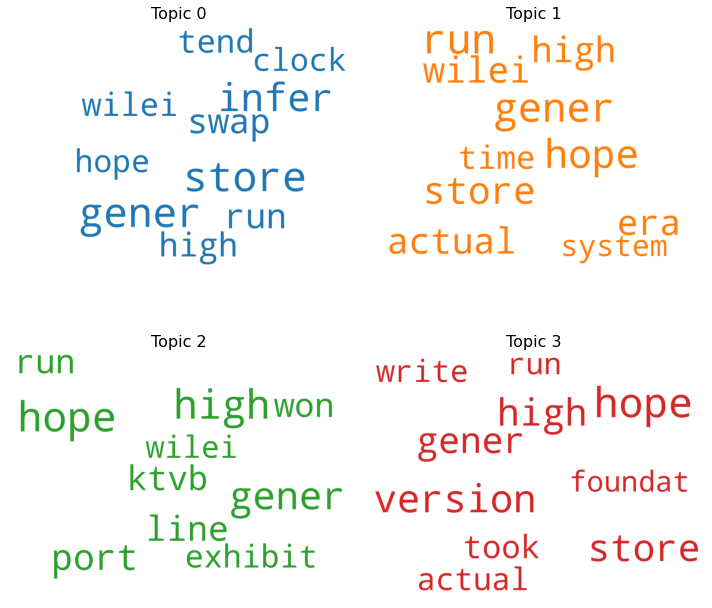

In [13]:
import matplotlib.colors as mcolors
import stop_words
from wordcloud import WordCloud

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics_1 = lda_1.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_1[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

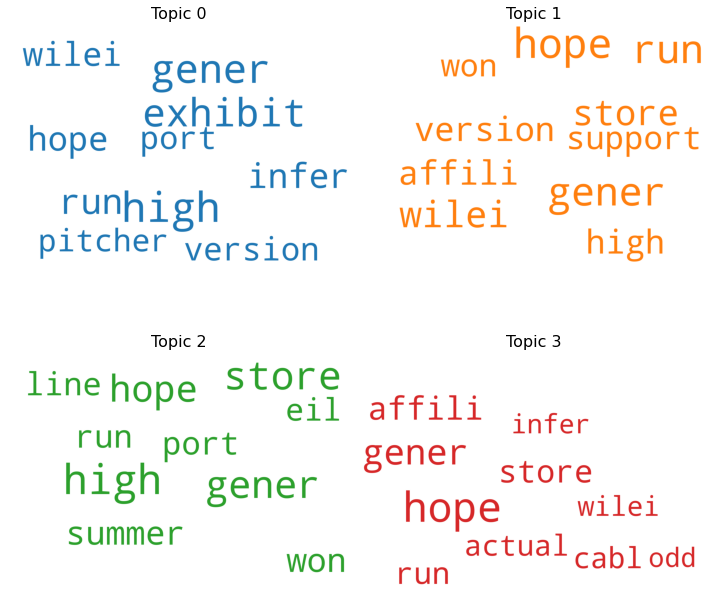

In [14]:
topics_2 = lda_2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_2[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

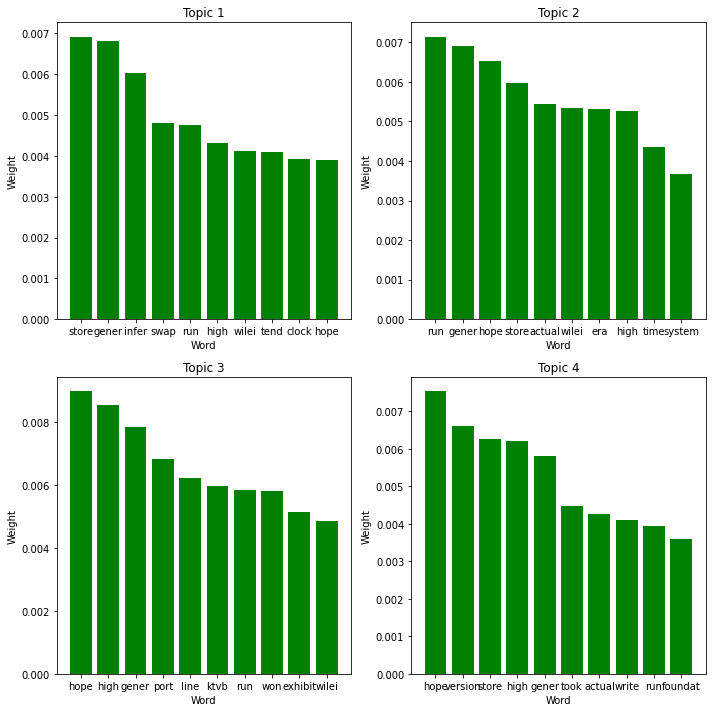

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_1[i][1])
    ax.set_title('Topic ' + str(i + 1), fontdict=dict(size=12))
    ax.bar(topic_words.keys(), topic_words.values(), color ='green')
    ax.set(xlabel='Word', ylabel="Weight")

fig.tight_layout()
plt.show()

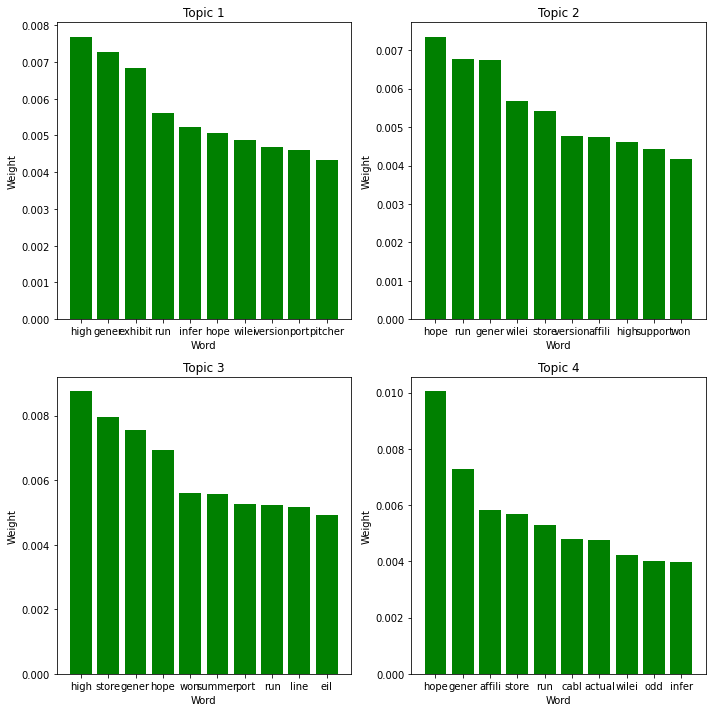

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics_2[i][1])
    ax.set_title('Topic ' + str(i + 1), fontdict=dict(size=12))
    ax.bar(topic_words.keys(), topic_words.values(), color ='green')
    ax.set(xlabel='Word', ylabel="Weight")

fig.tight_layout()
plt.show()

### Finally, refine the corpus with the vocab

In [17]:
new_corpus = [[w for w in doc if w in dictionary.token2id] for doc in corpus1]
print(len(new_corpus))
print(corpus1[0])
print(new_corpus[0])


1000
['morgan', 'guzman', 'era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'harkei', 'hibbard', 'castillo', 'won', 'good', 'think', 'stud', 'pitcher']
['era', 'run', 'higher', 'year', 'cub', 'idiot', 'pitch', 'won', 'good', 'think', 'pitcher']


In [18]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

# https://radimrehurek.com/gensim/models/word2vec.html
model_w2v = Word2Vec(sentences=corpus1, vector_size=100, window=5, min_count=1, workers=4)
model_w2v.save("word2vec.model")


In [19]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents1_d2v = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus1)]
model1_d2v = Doc2Vec(documents1_d2v, vector_size=5, window=2, min_count=1, workers=4)
corpus1_d2v = [model1_d2v.infer_vector(corpus1[i]) for i in range(len(corpus1))]

documents2_d2v = [TaggedDocument(doc, [i]) for i, doc in enumerate(new_corpus)]
model2_d2v = Doc2Vec(documents2_d2v, vector_size=5, window=2, min_count=1, workers=4)
corpus2_d2v = [model2_d2v.infer_vector(corpus1[i]) for i in range(len(new_corpus))]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f15f7941c20> (for post_execute):


KeyboardInterrupt: ignored

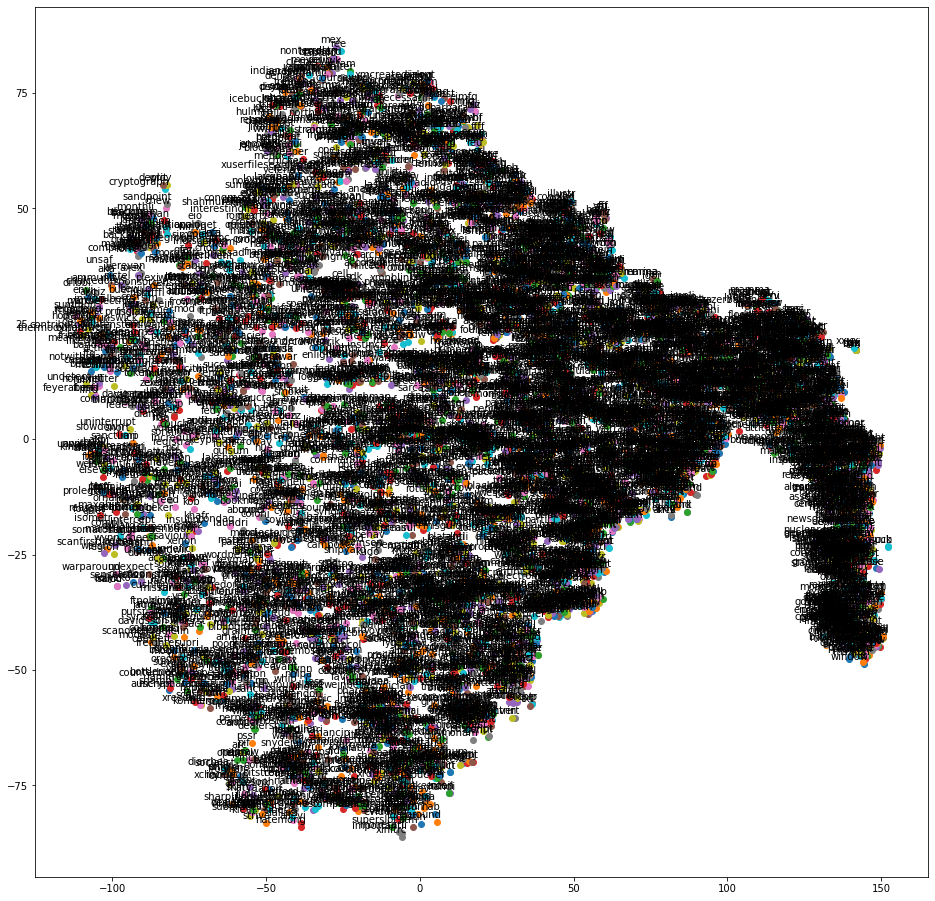

In [37]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    for word in model.wv.index_to_key:
      tokens.append(model.wv[word])
      labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(model1_d2v)

### Predict Funtion

In [21]:
from gensim.matutils import corpus2dense
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

def k_fit_predict(corpus_list, nmis_list, gnd, K):
  km = KMeans(n_clusters=K)
  sc = SpectralClustering(n_clusters=K, n_init=1) # spectral clustering model
  ac = AgglomerativeClustering(n_clusters=K) # hierarchical clustering model

  c_list = [km, sc, ac]

  for i in range(3):
    for j in corpus_list:
      temp = c_list[i].fit_predict(j)
      nmis_list[i].append(nmi_score(gnd, temp))
  

In [22]:
num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

corpus1_bows_dense = corpus2dense(corpus1_bows, num_terms, num_docs) # create dense matrix
corpus1_tfidf_dense = corpus2dense(corpus1_tf_idf, num_terms, num_docs)
corpus1_lda_dense = corpus2dense(corpus1_lda, num_terms, num_docs)

corpus_list = [corpus1_bows_dense.T, corpus1_tfidf_dense.T, corpus1_lda_dense.T, corpus1_d2v]

nmis_1 = []
nmis_1_sc = []
nmis_1_ac = []

nmis_list = [nmis_1, nmis_1_sc, nmis_1_ac]

gnd = labels[:1000]
K = len(set(gnd))

k_fit_predict(corpus_list, nmis_list, gnd, K)

print('Complete')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:376: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:376: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)


Complete


In [23]:
cluster_names = ['K-means', 'Spectral', 'Hierarchial']

for i in range(3):
  print(f'{cluster_names[i]}: {nmis_list[i]}')

K-means: [0.051702314952187425, 0.3265741776557747, 0.10729880014699483, 0.1136327873395028]
Spectral: [0.007998691625730593, 0.32834465703023796, 0.1100070586508859, 0.002096797312219582]
Hierarchial: [0.06087608079274574, 0.3196057445166326, 0.10518627229801766, 0.10648490293898012]


In [24]:
from gensim.matutils import corpus2dense
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

num_docs = dictionary.num_docs
num_terms = len(dictionary.keys())

corpus1_bows_dense = corpus2dense(corpus1_bows, num_terms, num_docs) # create dense matrix
corpus1_tfidf_dense = corpus2dense(corpus1_tf_idf, num_terms, num_docs)
corpus1_lda_dense = corpus2dense(corpus1_lda, num_terms, num_docs)

nmis_1 = []
gnd = labels[:1000]
K = len(set(gnd))
km_bow = KMeans(n_clusters=K)
km_tfidf = KMeans(n_clusters=K)
km_lda = KMeans(n_clusters=K)
km_d2v = KMeans(n_clusters=K)
cluster_bow = km_bow.fit_predict(corpus1_bows_dense.T)
cluster_tfidf = km_tfidf.fit_predict(corpus1_tfidf_dense.T)
cluster_lda = km_lda.fit_predict(corpus1_lda_dense.T)
cluster_d2v = km_d2v.fit_predict(corpus1_d2v)
nmis_1.append(nmi_score(gnd, cluster_bow))
nmis_1.append(nmi_score(gnd, cluster_tfidf))
nmis_1.append(nmi_score(gnd, cluster_lda))
nmis_1.append(nmi_score(gnd, cluster_d2v))
print("Vocab_v1")
print(nmis_1)




Vocab_v1
[0.061992754243876985, 0.06126989680569312, 0.1022245151975104, 0.11435477217759588]


In [25]:

num_docs = dict2.num_docs
num_terms = len(dict2.keys())

corpus2_bows_dense = corpus2dense(corpus2_bows, num_terms, num_docs) # create dense matrix
corpus2_tfidf_dense = corpus2dense(corpus2_tf_idf, num_terms, num_docs)
corpus2_lda_dense = corpus2dense(corpus2_lda, num_terms, num_docs)

nmis_2 = []
gnd = labels[:1000]
K = len(set(gnd))
km_bow = KMeans(n_clusters=K)
km_tfidf = KMeans(n_clusters=K)
km_lda = KMeans(n_clusters=K)
km_d2v = KMeans(n_clusters=K)
cluster_bow = km_bow.fit_predict(corpus2_bows_dense.T)
cluster_tfidf = km_tfidf.fit_predict(corpus2_tfidf_dense.T)
cluster_lda = km_lda.fit_predict(corpus2_lda_dense.T)
cluster_d2v = km_d2v.fit_predict(corpus2_d2v)
nmis_2.append(nmi_score(gnd, cluster_bow))
nmis_2.append(nmi_score(gnd, cluster_tfidf))
nmis_2.append(nmi_score(gnd, cluster_lda))
nmis_2.append(nmi_score(gnd, cluster_d2v))
print("Vocab_v2")
print(nmis_2)

Vocab_v2
[0.06312288274233269, 0.2857215638798209, 0.1168208679552904, 0.09914962947288818]


In [21]:
from tabulate import tabulate

nmi = (nmis_1, nmis_2)
table = tabulate(nmi, headers=["Vocabulary" , "BoW", "TF-IDF", "LDA", "Doc2Vec"], tablefmt='orgtbl')

print(table)

|   Vocabulary |      BoW |   TF-IDF |      LDA |
|--------------+----------+----------+----------|
|    0.0560289 | 0.341936 | 0.130307 | 0.236329 |
|    0.052579  | 0.302357 | 0.131569 | 0.295168 |


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


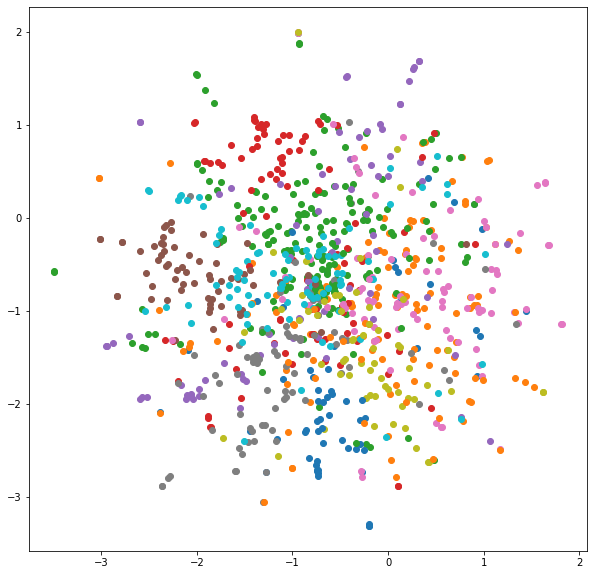

In [23]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2)
X = tsne_model.fit_transform(corpus2_tfidf_dense.transpose())
        
plt.figure(figsize=(10, 10)) 
for i in range(K):
    plt.scatter(X[cluster_tfidf == i, 0], X[cluster_tfidf == i, 1], alpha=1, label=cluster_tfidf[i])

plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


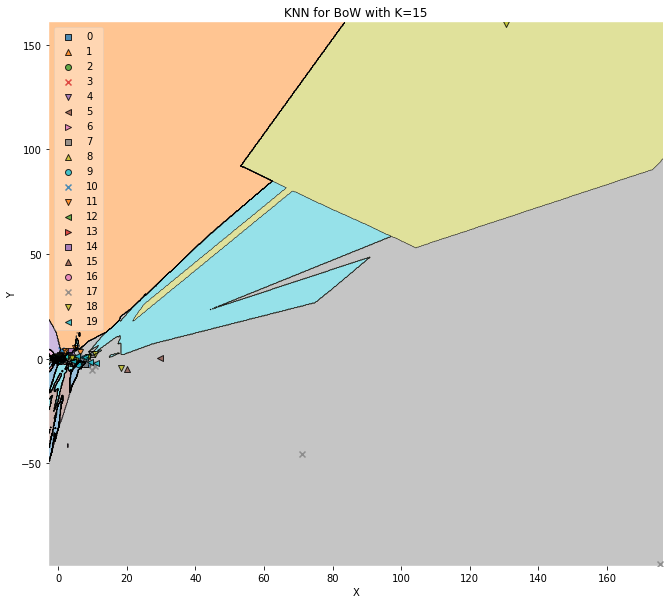

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

k = 15
gnd = labels[:1000]
knn = KNeighborsClassifier(n_neighbors=k)
pca = PCA(n_components = 2)
corpus2_bows_dense_train = pca.fit_transform(corpus2_bows_dense.T)
knn.fit(corpus2_bows_dense_train, gnd)
plot_decision_regions(corpus2_bows_dense_train, gnd, clf=knn, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("KNN for BoW with K="+ str(k))
plt.rcParams["figure.figsize"] = (11,10)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


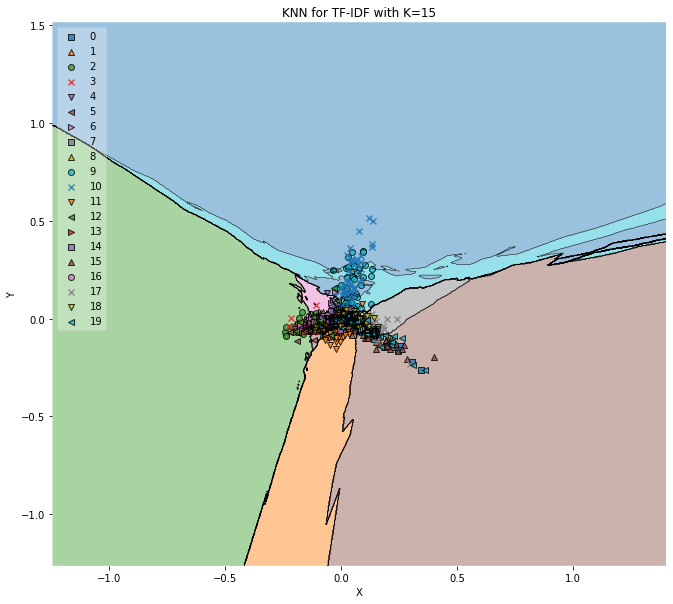

In [28]:
knn = KNeighborsClassifier(n_neighbors=k)
pca = PCA(n_components = 2)
corpus2_tfidf_dense_train = pca.fit_transform(corpus2_tfidf_dense.T)
knn.fit(corpus2_tfidf_dense_train, gnd)
plot_decision_regions(corpus2_tfidf_dense_train, gnd, clf=knn, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("KNN for TF-IDF with K="+ str(k))
plt.rcParams["figure.figsize"] = (11,10)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


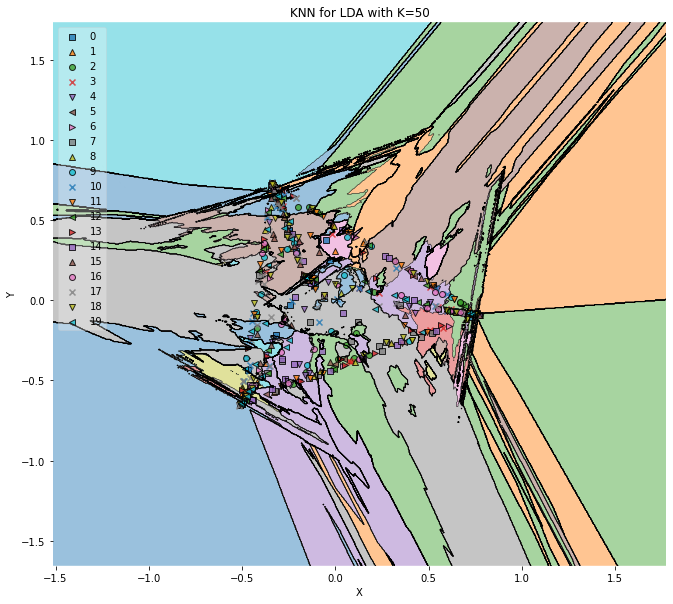

In [33]:
k = 50
knn = KNeighborsClassifier(n_neighbors=k)
pca = PCA(n_components = 2)
corpus2_lda_dense_train = pca.fit_transform(corpus2_lda_dense.T)
knn.fit(corpus2_lda_dense_train, gnd)
plot_decision_regions(corpus2_lda_dense_train, gnd, clf=knn, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("KNN for LDA with K="+ str(k))
plt.rcParams["figure.figsize"] = (11,10)
plt.show()

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


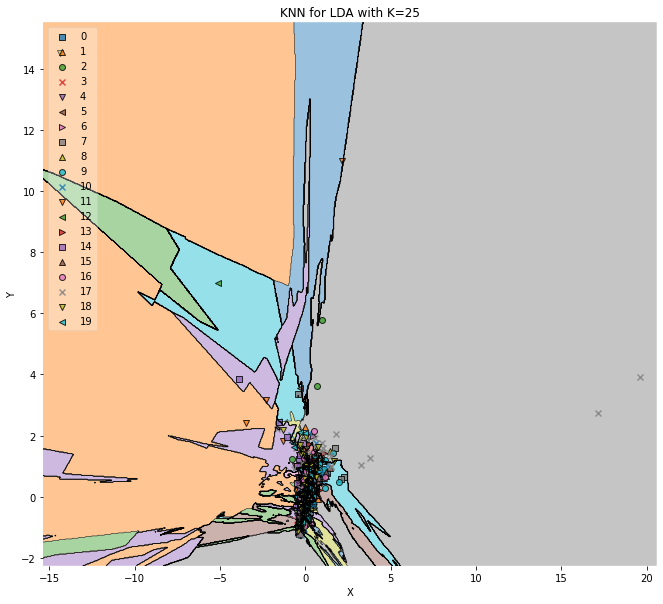

In [36]:
k = 25
knn = KNeighborsClassifier(n_neighbors=k)
pca = PCA(n_components = 2)
corpus2_d2v_dense_train = pca.fit_transform(corpus2_d2v)
knn.fit(corpus2_d2v_dense_train, gnd)
plot_decision_regions(corpus2_d2v_dense_train, gnd, clf=knn, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("KNN for LDA with K="+ str(k))
plt.rcParams["figure.figsize"] = (11,10)
plt.show()

### Conclusion

Please follow the Gensim tutorials for learning document representations in the final project:
- [Corpus and vector space](https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html#sphx-glr-auto-examples-core-run-corpora-and-vector-spaces-py)
- [TF-IDF](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html#sphx-glr-auto-examples-core-run-topics-and-transformations-py)
- [LDA](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py) (**Note that, TF-IDF is not the input for training a LDA model.**)
- [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py) and [Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)